In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import pyocr
import pyocr.builders
import pytesseract
from PIL import Image
from tqdm import tqdm

from lib.data import load_extracted_samples, load_all_invoices
from lib.ocr import try_extract_from_ocr

In [3]:
samples = load_extracted_samples()
samples = [s for s in samples if len(s["text"]) == 0]

In [4]:
samples[1]

{'filename': '108017661.pdf',
 'size': 1957491,
 'pages': 2,
 'text': '',
 'images': ['/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/108017661.pdf/0.png',
  '/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/108017661.pdf/1.png']}

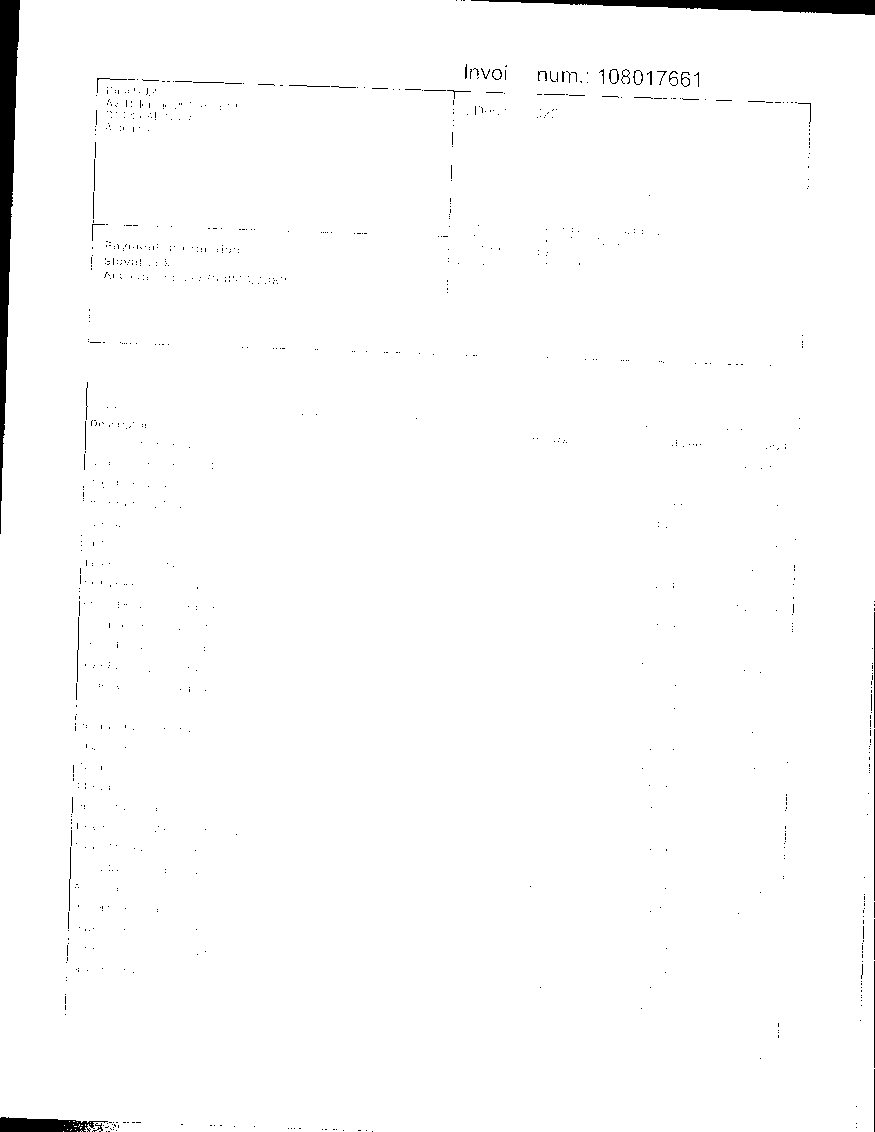

In [5]:
test_img = samples[1]["images"][0]

image_file = Image.open(test_img)
# Grayscale
image_file = image_file.convert('L')
# Threshold
image_file = image_file.point( lambda p: 255 if p > 100 else 0 )
# To mono
image_file = image_file.convert('1')
image_file

In [6]:

for sample in tqdm(samples):
    sample = sample.update(try_extract_from_ocr(sample))


100%|██████████| 78/78 [02:17<00:00,  1.76s/it]


In [10]:

invoices = load_all_invoices()
len(invoices)

8411

In [15]:
samples_df = pd.DataFrame(samples)
samples_df["invoice"].value_counts()

invoice
ParaisUR     1
165376049    1
171568145    1
178546494    1
18454074     1
18835955     1
195935821    1
1            1
199116904    1
963186898    1
C40931119    1
Q64788539    1
327423467    1
93250096     1
N70218035    1
376922889    1
574419090    1
165788165    1
161144530    1
108558649    1
155957482    1
114482558    1
115101396    1
116065291    1
11966415     1
119937389    1
121428420    1
1239810      1
125551296    1
12671        1
13099445     1
133820690    1
139326713    1
141514961    1
146741953    1
148807166    1
492201732    1
Name: count, dtype: int64

In [18]:
# lambda
samples_df[samples_df["invoice"].apply(lambda x: x in invoices)]

,filename,size,pages,text,images,invoice,total
2,108558649.pdf,204688,2,,[/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extr...,108558649,30273.20
5,114482558.pdf,447785,1,,[/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extr...,114482558,7355.27
6,115101396.pdf,416200,2,,[/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extr...,115101396,42881.24
7,116065291.pdf,1444099,2,,[/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extr...,116065291,NaN
8,11966415.pdf,1430782,2,,[/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extr...,11966415,41885.90
9,119937389.pdf,1888663,2,,[/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extr...,119937389,14554.86
11,121428420.pdf,1339579,2,,[/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extr...,121428420,42431.52
15,125551296.pdf,1074943,2,,[/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extr...,125551296,23608.84
18,13099445.pdf,1187609,2,,[/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extr...,13099445,37866.99
19,133820690.pdf,1775733,2,,[/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extr...,133820690,43193.16
